# Использование `K-means` для сжатия


Еще одно полезное применение кластеризации — сжатие изображений. Схема до удивления проста: похожие, рядом расположенные цвета, стоит объединить в один цвет. Давайте провернем это самостоятельно.

Считайте изображение из вашего индивидуального задания.

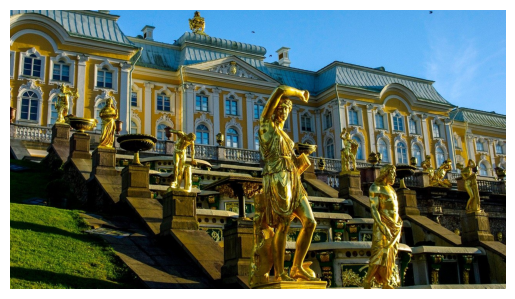

In [14]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import numpy as np


# Путь к изображению
img_path = 'spb_statues.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

Перед нами трехканальное (RGB) изображение. Вычислите среднее значение интенсивности пикселей по всем каналам.

In [3]:
mean_intensity = np.mean(img, axis=(0, 1))

# mean_intensity теперь содержит среднее значение интенсивности по каналам (R, G, B)
print("Среднее значение интенсивности (R, G, B):", mean_intensity)

Среднее значение интенсивности (R, G, B): [81.59171007 93.97419379 79.21900716]


In [5]:
np.mean([81.59171007, 93.97419379, 79.21900716])

84.92830367333333

Нормируйте значения интенсивностей пикселей, разделив все значения на $255$. Вычислите среднее значение интенсивности пикселей по всем каналам после проделанного преобразования.

In [15]:
normalized_img = img / 255.0

# Вычисление среднего значения интенсивности пикселей по всем каналам после нормирования
mean_intensity_normalized = np.mean(normalized_img, axis=(0, 1))

# mean_intensity_normalized теперь содержит среднее значение интенсивности по каналам (R, G, B) после нормирования
print("Среднее значение интенсивности (R, G, B) после нормирования:", mean_intensity_normalized)

Среднее значение интенсивности (R, G, B) после нормирования: [0.31996749 0.36852625 0.31066277]


In [7]:
np.mean([0.31996749, 0.36852625, 0.31066277])

0.33305217

Давайте убедимся в том, что исходное пространство цветов, насчитывающее около $16$ миллионов возможных состояний ($256^3$), слишком велико, и его размерность можно понижать. Для наглядности построим лишь некоторые подвыборки зависимостей значений интенсивностей и лишь на случайном поднаборе пикселей.

«Распрямите» изображение так, чтобы <code>.shape</code> соответствущего массива имел вид <code>(высота * ширина, 3)</code>

In [12]:
# Функция принимает на вход "распрямленный" массив, соответствующий изображению

def plot_pixels(data, colors=None, N=10000):
    if colors is None:
        colors = data

    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, c=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, c=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

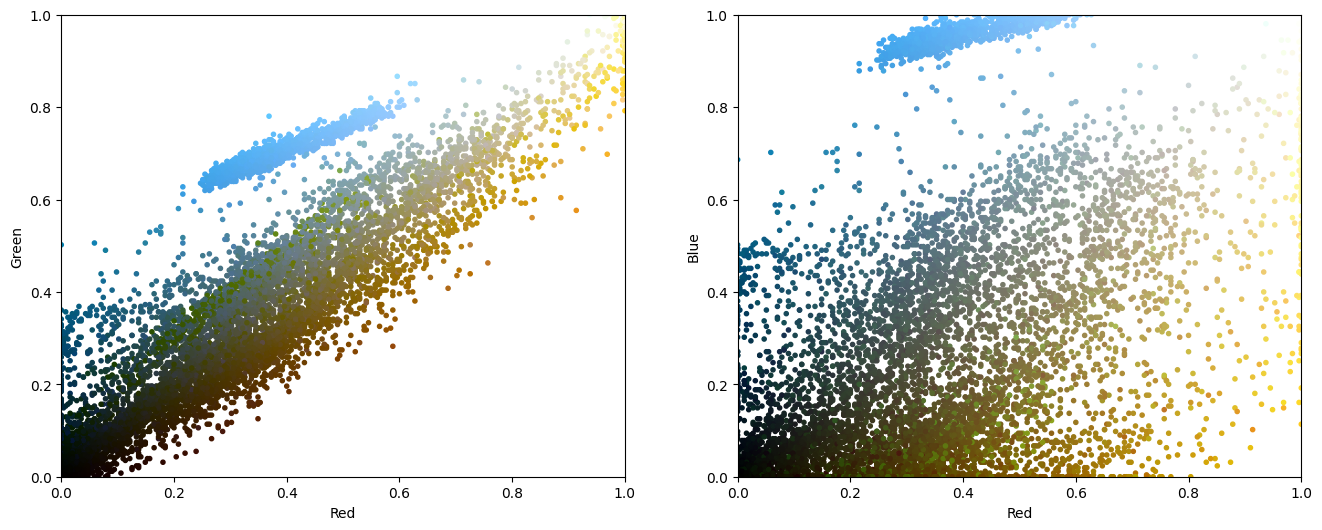

In [16]:
img = normalized_img
# Распрямление изображения
height, width, _ = img.shape
flattened_img = img.reshape((height * width, 3))

# Вызов функции для построения графиков
plot_pixels(flattened_img)

plt.show()

Переведем 16 миллионов возможностей во всего-навсего 16 возможностей, используя <code>K-means</code>. Правда, чтобы ускорить работу алгоритма, мы будем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html"><code>K-means</code> на батчах</a> — поднаборах данных. Заодно увидим, портит ли это результат.

Обучите модель <code>MiniBatchKMeans</code> на нормированном и «распрямленном» изображении с параметрами, указанными в вашем задании.

В изображении замените значения цветов каждого пикселя на значения координат центроида кластера к которому был отнесен этот пиксель. Постройте графики зависимостей цветов при помощи <code>plot_pixels()</code> с новой палитрой (параметр <code>colors</code>)


In [17]:
from sklearn.cluster import MiniBatchKMeans

# Создайте экземпляр модели MiniBatchKMeans
n_clusters = 16
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=18)

# Обучите модель на "распрямленном" и нормированном изображении
kmeans.fit(flattened_img)

# Получите метки кластеров для каждого пикселя
labels = kmeans.labels_

# Получите координаты центроидов кластеров
cluster_centers = kmeans.cluster_centers_

# Замените значения цветов каждого пикселя на значения координат центроида кластера
compressed_img = cluster_centers[labels]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Вычислите среднее значение интенсивности пикселей полученного изображения.

In [24]:
# Вычислите среднее значение интенсивности пикселей полученного изображения
mean_intensity_compressed = np.mean(compressed_img, axis=(0, 1))

print("Среднее значение интенсивности пикселей после кластеризации:", mean_intensity_compressed)

Среднее значение интенсивности пикселей после кластеризации: 0.33210763446333524


Выберите номер изображения, соответствующего палитре из $16$ цветов.

In [21]:
# Вызов функции plot_pixels с новой палитрой (цветами центроидов кластеров)
plot_pixels(compressed_img, colors=cluster_centers)

plt.show()

IndexError: ignored

Пора смотреть на результат! Постройте рядом оригинальное изображение и изображение, в котором используется лишь $16$ цветов.

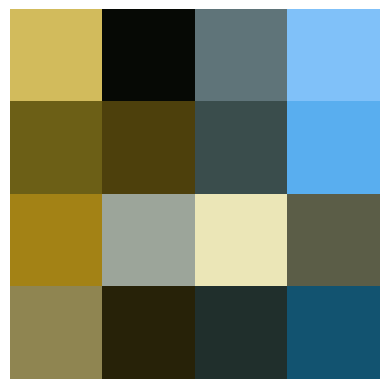

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Выберем палитру цветов (cluster_centers) для построения изображения
palette = cluster_centers
# Создаем изображение размером 4x4
image = np.reshape(palette, (4, 4, 3))

# Отобразим изображение
plt.imshow(image)
plt.axis('off')
plt.show()


Постройте изображение размера $4 \times 4$ на основе полученных $16$ цветов. Выберите верное изображение.

In [ ]:
# < ENTER YOUR CODE HERE >